# Transfer Learning for Pest Identification
## By Wesley Giles

### Setup
- Download the image data and place the `.tar` file at the location `./data/Classification/ip102_v1.1.tar`


In [28]:
import pandas as pd
import tarfile
import os
import shutil

In [29]:
root_path = "./data/Classification/ip102_v1.1"

In [30]:
if not os.path.isdir(root_path):
  tarfile.TarFile(f"./data/Classification/ip102_v1.1.tar").extractall("./data/Classification/")

In [31]:
train_labels = pd.read_csv(f"{root_path}/train.txt", sep=" ", header=None)
test_labels = pd.read_csv(f"{root_path}/test.txt", sep=" ", header=None)
val_labels = pd.read_csv(f"{root_path}/val.txt", sep=" ", header=None)

for df in [train_labels, test_labels, val_labels]:
  df.columns = ["img","label"]
  print(df.shape)

(45095, 2)
(22619, 2)
(7508, 2)


In [32]:
class_names = pd.read_csv("./data/Classification/classes.txt", header=None)
class_names[0] = class_names[0].str.strip()
class_names["label"] = class_names[0].str.extract(r"^(\d+)").astype(int)
class_names['name'] = class_names[0].str.extract(r"^\d+ (.*)")
class_names = class_names.drop(0, axis= 1)
class_names

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer
...,...,...
97,98,Chlumetia transversa
98,99,Mango flat beak leafhopper
99,100,Rhytidodera bowrinii white
100,101,Sternochetus frigidus


In [33]:
train_labels = train_labels.join(class_names, on="label", how="left", rsuffix="_")
test_labels = test_labels.join(class_names, on="label", how="left", rsuffix="_")
val_labels = val_labels.join(class_names, on="label", how="left", rsuffix="_")

In [34]:
try:
  for dataset in ["train","test","val"]:
    df = globals()[f"{dataset}_labels"]
    for _, row in df.iterrows():
      expected_path = f"{root_path}/{dataset}/{row['name']}"
      if not os.path.isdir(expected_path):
        os.makedirs(expected_path)
      shutil.move(f"{root_path}/images/{row['img']}",f"{expected_path}/{row['img']}")
except Exception as e:
  print(e)

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [36]:
train_dataset = tf.keras.utils.image_dataset_from_directory(f"{root_path}/train",
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(160, 160))

Found 45095 files belonging to 102 classes.


In [37]:
test_dataset = tf.keras.utils.image_dataset_from_directory(f"{root_path}/test",
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(160, 160))

Found 22619 files belonging to 102 classes.


In [38]:
val_dataset = tf.keras.utils.image_dataset_from_directory(f"{root_path}/val",
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(160, 160))

Found 7508 files belonging to 102 classes.


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [40]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [41]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [42]:
IMG_SHAPE = (160, 160, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [43]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [44]:
base_model.trainable = False

In [45]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [47]:
prediction_layer = tf.keras.layers.Dense(102, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 102)


In [48]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [50]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_dataset)

235/235 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - categorical_accuracy: 0.0085 - loss: 5.1470


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 247s 173ms/step - categorical_accuracy: 0.0141 - loss: 4.6677 - val_categorical_accuracy: 0.0104 - val_loss: 4.3823
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 223s 158ms/step - categorical_accuracy: 0.0173 - loss: 4.4805 - val_categorical_accuracy: 0.0140 - val_loss: 4.3362
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 222s 157ms/step - categorical_accuracy: 0.0163 - loss: 4.4293 - val_categorical_accuracy: 0.0108 - val_loss: 4.3178
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 222s 157ms/step - categorical_accuracy: 0.0194 - loss: 4.3928 - val_categorical_accuracy: 0.0139 - val_loss: 4.2852
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 222s 157ms/step - categorical_accuracy: 0.0169 - loss: 4.3633 - val_categorical_accuracy: 0.0133 - val_loss: 4.2758
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 225s 160ms/step - categorical_accuracy: 0.0157 - loss: 4.3464 - val_categorical_accuracy: 0.0125 - val_loss: 4.2693
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 221s 157ms

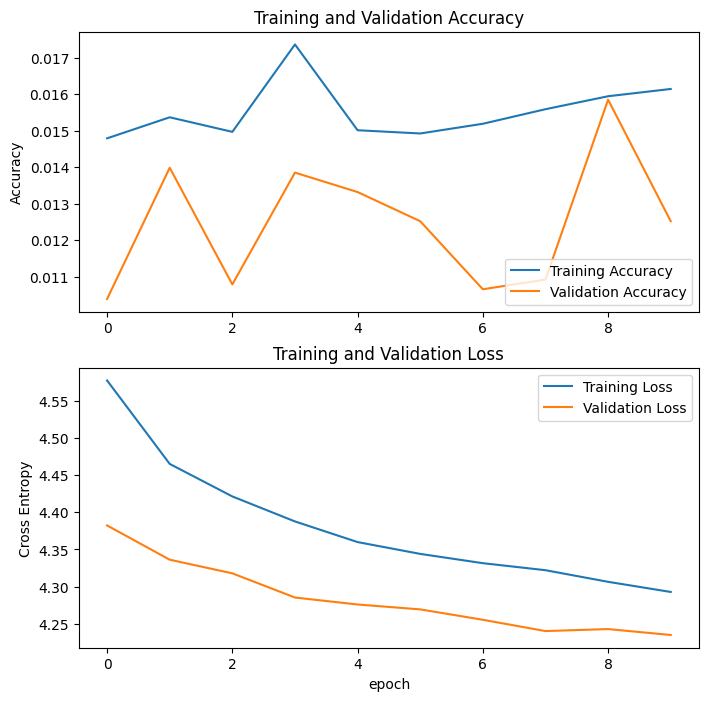

In [35]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
history.history.keys()

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])